In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.observable import *

sys.modules['oom'] = oom

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [14]:
n_obs = 4
src_dim = 8
learnlen = 70000
testlen = 30000

random_oom = DiscreteValuedOOM.from_sparse(
    src_dim,
    density = 0.3,
    alphabet_size = n_obs,
    deterministic_functional = False
)
# print("\nGenerated OOM\n", random_oom)
_, nlls_ground, seq, ps_ground = random_oom.generate(length = learnlen + testlen)
_, nlls_ground_test, ps_ground_test = random_oom.compute(seq[learnlen:])
# del random_oom

dim_search = [4, 5, 6, 7, 8, 9, 10, 11, 12]
max_length = int(max(np.log2(dim_search)))

nlls_err_learned = []

for idx, target_dim in enumerate(dim_search):
    learned_oom = DiscreteValuedOOM.from_data(
        seq,
        target_dim,
        max_length = max_length
    )
    
    # Save difference in nll from ground (min) to learned
    _, nlls_learned_test, ps_learned_test = learned_oom.compute(seq[learnlen:])
    nlls_err_learned.append(nlls_learned_test[-1])
    
    # del learned_oom
    # del nlls_learned_test

target_dimension=4, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=5, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=6, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=7, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=8, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=9, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=10, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=11, max_length=3: substr_len = 2 3 4 5 6 7 | Done
target_dimension=12, max_length=3: substr_len = 2 3 4 5 6 7 | Done


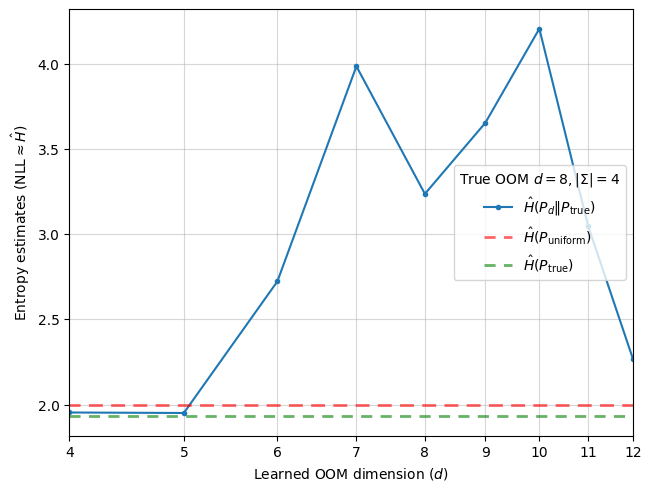

In [15]:
import matplotlib as mpl
from matplotlib import pyplot as plt
xlims = [min(dim_search), max(dim_search)]

fig = plt.figure()
ax = plt.gca()

# Entropy estimates of learned OOMs on test sequence (by dimension)
ax.plot(dim_search, nlls_err_learned,
         marker='o', markersize=3,
         label = r"$\hat{H}(P_d \Vert P_\text{true})$")

# Entropy of uniform process
ax.hlines(y = np.log2(n_obs), xmin=xlims[0], xmax=xlims[1],
           color='r', ls=(1, (5, 3)), linewidth=2, alpha=0.6,
           label = r"$\hat{H}(P_\text{uniform})$")

# Entropy estimates of ground OOM on test sequence
ax.hlines(y = nlls_ground[-1], xmin=xlims[0], xmax=xlims[1],
           color='g', ls=(0, (4, 3)), linewidth=2, alpha=0.6,
           label = r"$\hat{H}(P_\text{true}$)")

ax.set_xscale('log', base=2)
ax.set_xticks(dim_search)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlim(xlims)
ax.set_xlabel("Learned OOM dimension ($d$)")

ax.set_ylabel("Entropy estimates ($\\text{NLL} \\approx \\hat{H}$)")

ax.legend(loc="center right", title=f"True OOM $d = {src_dim}, \\vert\\Sigma\\vert = {n_obs}$")
ax.grid(True, alpha=0.5)

fig.set_layout_engine("constrained")

plt.show()

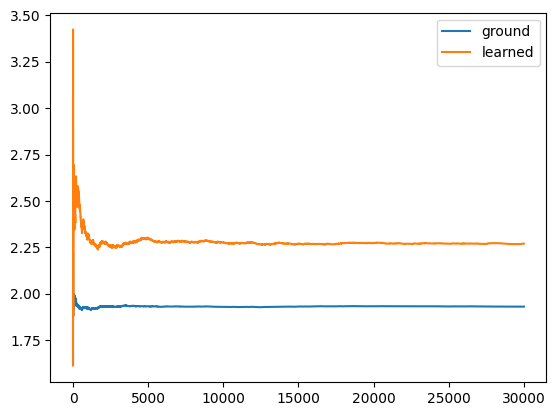

In [16]:
plt.figure()
ax = plt.gca()

# ax.set_xscale('log', base=2)
# ax.set_xticks(dim_search)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xlim(xlims)

ax.plot(nlls_ground_test, label="ground")
ax.plot(nlls_learned_test, label="learned")
ax.legend()

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (5, 3))
axs = axs.flatten()

from IPython import display
hdisplay = display.display("", display_id=True)

ooms = [random_oom, learned_oom]
state = [states_ground, states_learned]

for stateidx in range(len(state[0])):
    for idx, ax in enumerate(axs):
        ax.clear()
        
        weights = np.array(ooms[idx].lf_on_operators * state[idx][stateidx]).flatten()
        values = np.arange(0, weights.shape[0] + 1)
        
        _, bins, _ = ax.hist(
            x = values[:-1],
            weights = weights,
            bins = values,
            align='mid',
            histtype='bar',
            edgecolor='k',
            facecolor='lightblue'
        )
        
        ax.axhline(
            np.mean(weights),
            color='r',
            ls='--'
        )
        
        ax.set_xticks(values)
        ax.set_xlim([min(values), max(values)])
        ax.set_ylim([min(-5, 1.2*min(weights)), max(5, 1.2*max(weights))])
    
    fig.set_layout_engine('constrained')
    # plt.show()
    hdisplay.update(fig)

In [ ]:


ooms = [random_oom, learned_oom]
# state = [states_ground, states_learned]
state = [states_ground, learned_oom.generate(length=testlen)[0]]

oomidx = 1

n_obs = len(ooms[oomidx].observables)
plts = [[] for _ in range(n_obs)]

for stateidx in range(len(state[oomidx])):
    weights = np.array(ooms[oomidx].lf_on_operators * state[oomidx][stateidx]).flatten()
    print(weights)

    for obsidx, item in enumerate(weights):
        plts[obsidx].append(item)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

for obsidx in range(n_obs):
    plt.plot(running_mean(plts[obsidx], 5000))

plt.show()

In [ ]:
state = learned_oom.start_state
for idx in range(50):
    opidx = np.random.randint(low=0, high=len(learned_oom.operators))
    state = learned_oom.operators[opidx](state)
    print(learned_oom.obsnames[opidx], np.array(learned_oom.lf_on_operators * state).flatten())

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

ps_hor = [[] for _ in range(len(ps_learned))]
ps_sums = []
for entry in ps_learned:
    for idx, val in enumerate(entry):
        ps_hor[idx].append(val)
    ps_sums.append(np.sum(entry))

In [ ]:
for idx, pvals in enumerate(ps_hor):
    plt.plot(running_mean(pvals, 10))
plt.plot(ps_sums)